In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [135]:
bottle = pd.read_csv('/kaggle/input/bottle/bottle.csv')
bottle.head(2)

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.44,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.44,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


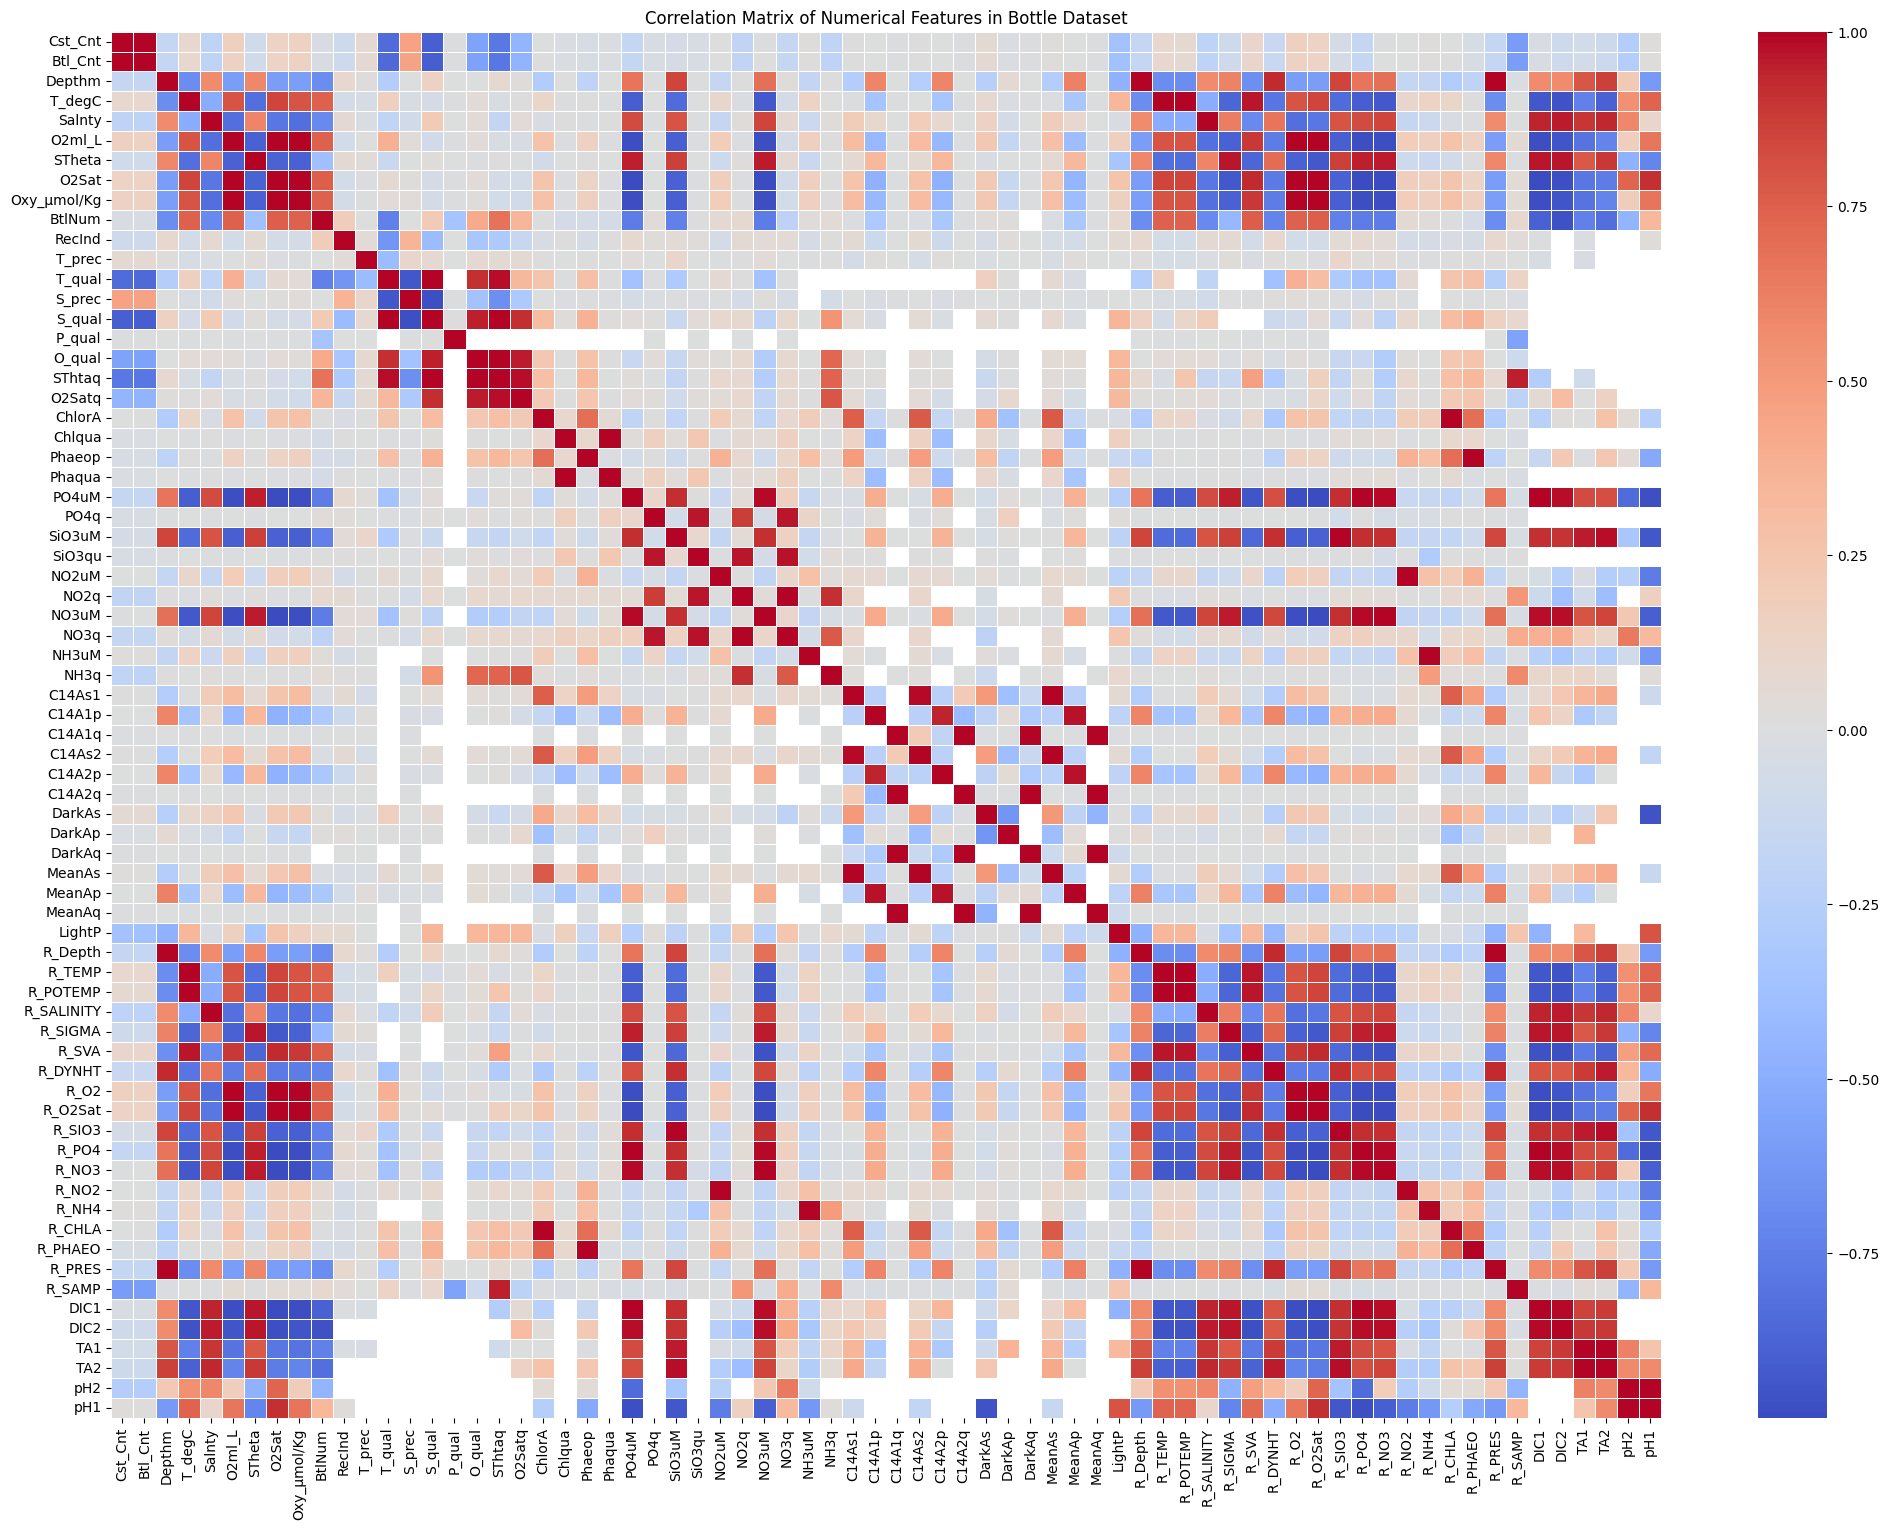

In [136]:
numerical_bottle = bottle.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numerical_bottle.corr()

# Plot the heatmap
plt.figure(figsize=(25, 18))
sns.heatmap(corr_matrix, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features in Bottle Dataset")
plt.show()

Correlation of features just with T_degC

We can see there are a lot of features not correlated

<Axes: >

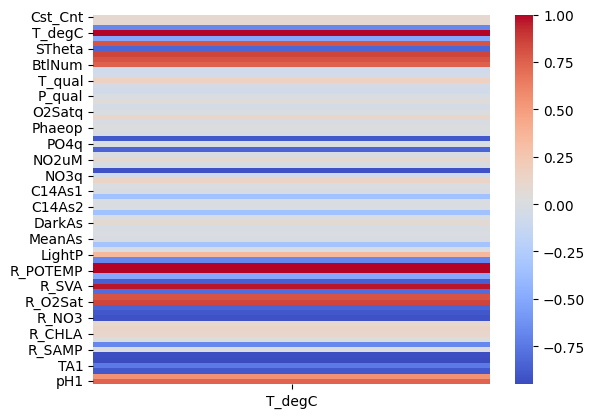

In [137]:
x = corr_matrix[['T_degC']]
sns.heatmap(x, cmap="coolwarm")

In [138]:
bottle.isnull().sum()

Cst_Cnt                     0
Btl_Cnt                     0
Sta_ID                      0
Depth_ID                    0
Depthm                      0
                        ...  
TA1                    862779
TA2                    864629
pH2                    864853
pH1                    864779
DIC Quality Comment    864808
Length: 74, dtype: int64

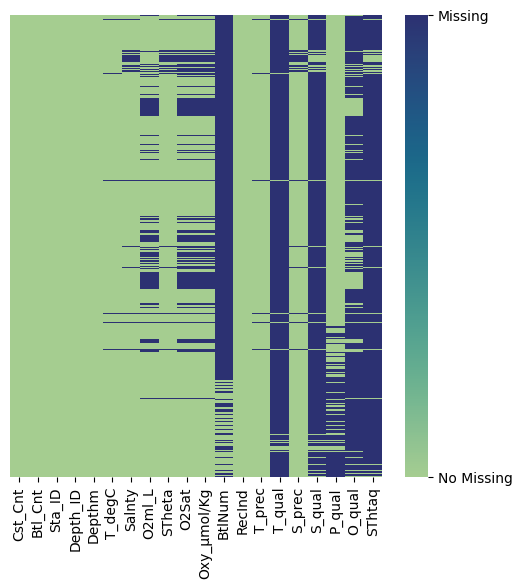

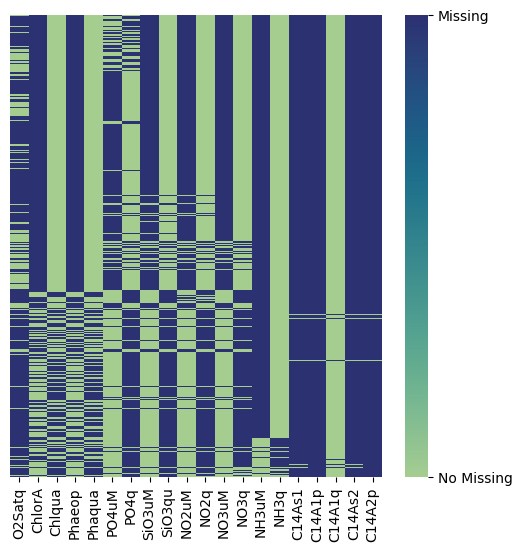

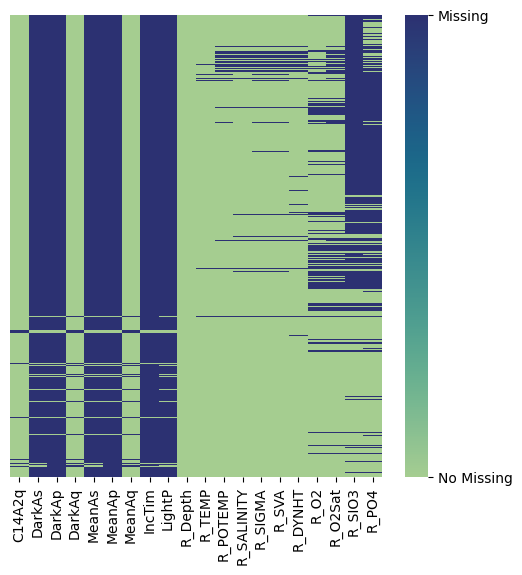

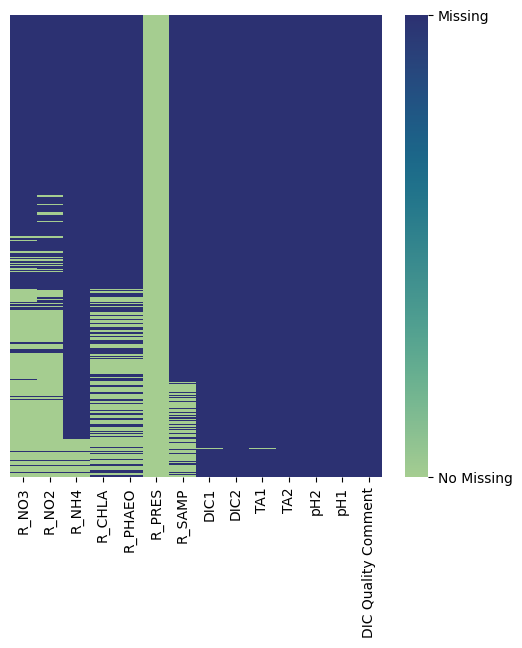

In [139]:
chunk_size = 20
for i in range(0, len(bottle.columns), chunk_size):
    plt.figure(figsize=(6, 6))
    heatmap = sns.heatmap(bottle.iloc[:, i:i + chunk_size].isna(),
                          cbar=True,
                          cmap="crest",
                          yticklabels=False) 

    # Custom legend
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_ticks([0, 1])
    colorbar.set_ticklabels(['No Missing', 'Missing'])

    #plt.title(f'Missing Data Heatmap: Columns {i} - {i + chunk_size - 1}')
    plt.show()

We noticed 2 things:

1. A lot of features aren't correlated with the target **T_degC**

2. A lot of features have missing values

So, we have decided to keep just the features that have a correlation > 0.5 with the target and that have less than 20% of missing values.
We are going to create a new dataset, **new_bottle** with selected features + T_degC (target)



New dataframe created with 13 features + T_degC.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Depthm      864863 non-null  int64  
 1   Salnty      817509 non-null  float64
 2   O2ml_L      696201 non-null  float64
 3   STheta      812174 non-null  float64
 4   R_Depth     864863 non-null  float64
 5   R_TEMP      853900 non-null  float64
 6   R_POTEMP    818816 non-null  float64
 7   R_SALINITY  817509 non-null  float64
 8   R_SIGMA     812007 non-null  float64
 9   R_SVA       812092 non-null  float64
 10  R_DYNHT     818206 non-null  float64
 11  R_O2        696201 non-null  float64
 12  R_PRES      864863 non-null  int64  
 13  T_degC      853900 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 92.4 MB
None


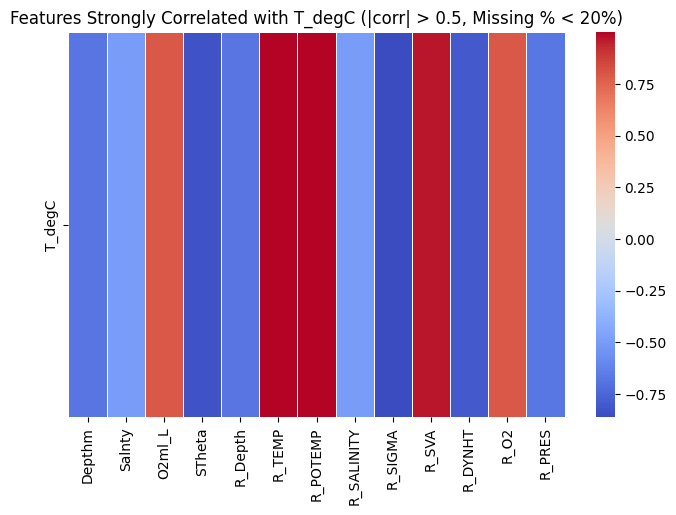

In [140]:
# Select numerical columns
numerical_bottle = bottle.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numerical_bottle.corr()

# Get correlation of all features with "T_degC"
target_corr = corr_matrix["T_degC"].drop("T_degC")  # Exclude self-correlation

# Compute percentage of missing values
missing_percent = numerical_bottle.isnull().mean() * 100

# Apply both conditions: |correlation| > 0.5 and missing percentage < 20%
valid_features = target_corr[(target_corr.abs() > 0.5) & (missing_percent < 20)].index.tolist()

# Create new dataframe with selected features + T_degC (to maintain target)
new_bottle = bottle[valid_features + ["T_degC"]]

# Print results
if not new_bottle.empty:
    print(f"New dataframe created with {len(valid_features)} features + T_degC.")
    print(new_bottle.info())

    # Visualize correlation heatmap for selected features
    plt.figure(figsize=(8, 5))
    sns.heatmap(corr_matrix.loc[["T_degC"], valid_features], annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Features Strongly Correlated with T_degC (|corr| > 0.5, Missing % < 20%)")
    plt.show()
else:
    print("No features meet both conditions. 'new_bottle' is empty.")

In [141]:
new_bottle.isnull().sum()

Depthm             0
Salnty         47354
O2ml_L        168662
STheta         52689
R_Depth            0
R_TEMP         10963
R_POTEMP       46047
R_SALINITY     47354
R_SIGMA        52856
R_SVA          52771
R_DYNHT        46657
R_O2          168662
R_PRES             0
T_degC         10963
dtype: int64

There are still a lot columns with missing values so we apply,

- the **median** where there is a missing values in a **numeric column**
- the **mode** where there is a missing values in a **categorical colum**

In [142]:
# Handling missing values
for column in new_bottle.columns:
    if new_bottle[column].dtype == 'object':  # Categorical column
        # Fill missing values with mode (most frequent value)
        new_bottle[column].fillna(new_bottle[column].mode()[0], inplace=True)
    else:  # Numeric column
        # Fill missing values with mean
        new_bottle[column].fillna(new_bottle[column].median(), inplace=True)

# Check the result after handling missing values
print(new_bottle.isnull().sum())

Depthm        0
Salnty        0
O2ml_L        0
STheta        0
R_Depth       0
R_TEMP        0
R_POTEMP      0
R_SALINITY    0
R_SIGMA       0
R_SVA         0
R_DYNHT       0
R_O2          0
R_PRES        0
T_degC        0
dtype: int64


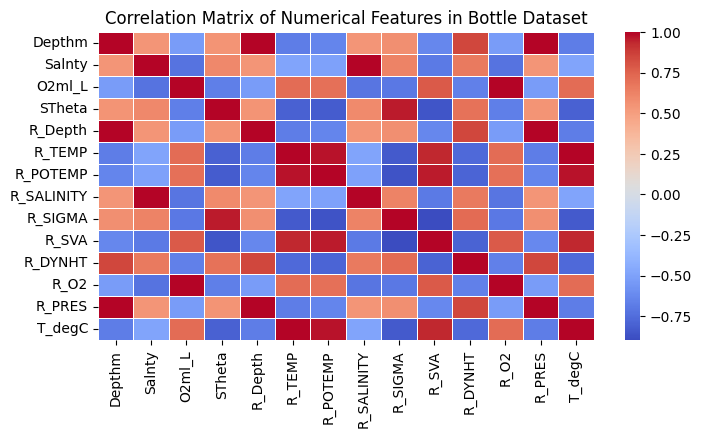

In [143]:
corr_matrix = new_bottle.corr()

# Plot the heatmap
plt.figure(figsize=(8,4))
sns.heatmap(corr_matrix, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features in Bottle Dataset")
plt.show()

In [144]:
# Check summary statistics for all features in the new dataset "new_bottle"
print(new_bottle.describe())

              Depthm         Salnty         O2ml_L         STheta  \
count  864863.000000  864863.000000  864863.000000  864863.000000   
mean      226.831951      33.841590       3.401738      25.830153   
std       316.050259       0.449051       1.860240       1.132444   
min         0.000000      28.431000      -0.010000      20.934000   
25%        46.000000      33.504000       1.890000      25.024000   
50%       125.000000      33.863000       3.440000      25.996000   
75%       300.000000      34.180000       5.240000      26.615000   
max      5351.000000      37.034000      11.130000     250.784000   

             R_Depth         R_TEMP       R_POTEMP     R_SALINITY  \
count  864863.000000  864863.000000  864863.000000  864863.000000   
mean      226.832495      10.790321      10.802774      33.841539   
std       316.050007       4.217657       4.125482       0.450154   
min         0.000000       1.440000       0.000000       4.570000   
25%        46.000000       7.7200

We want to explore the distribution of values in the features of the new dataset

Some scatter plot to see how a feature effects the target

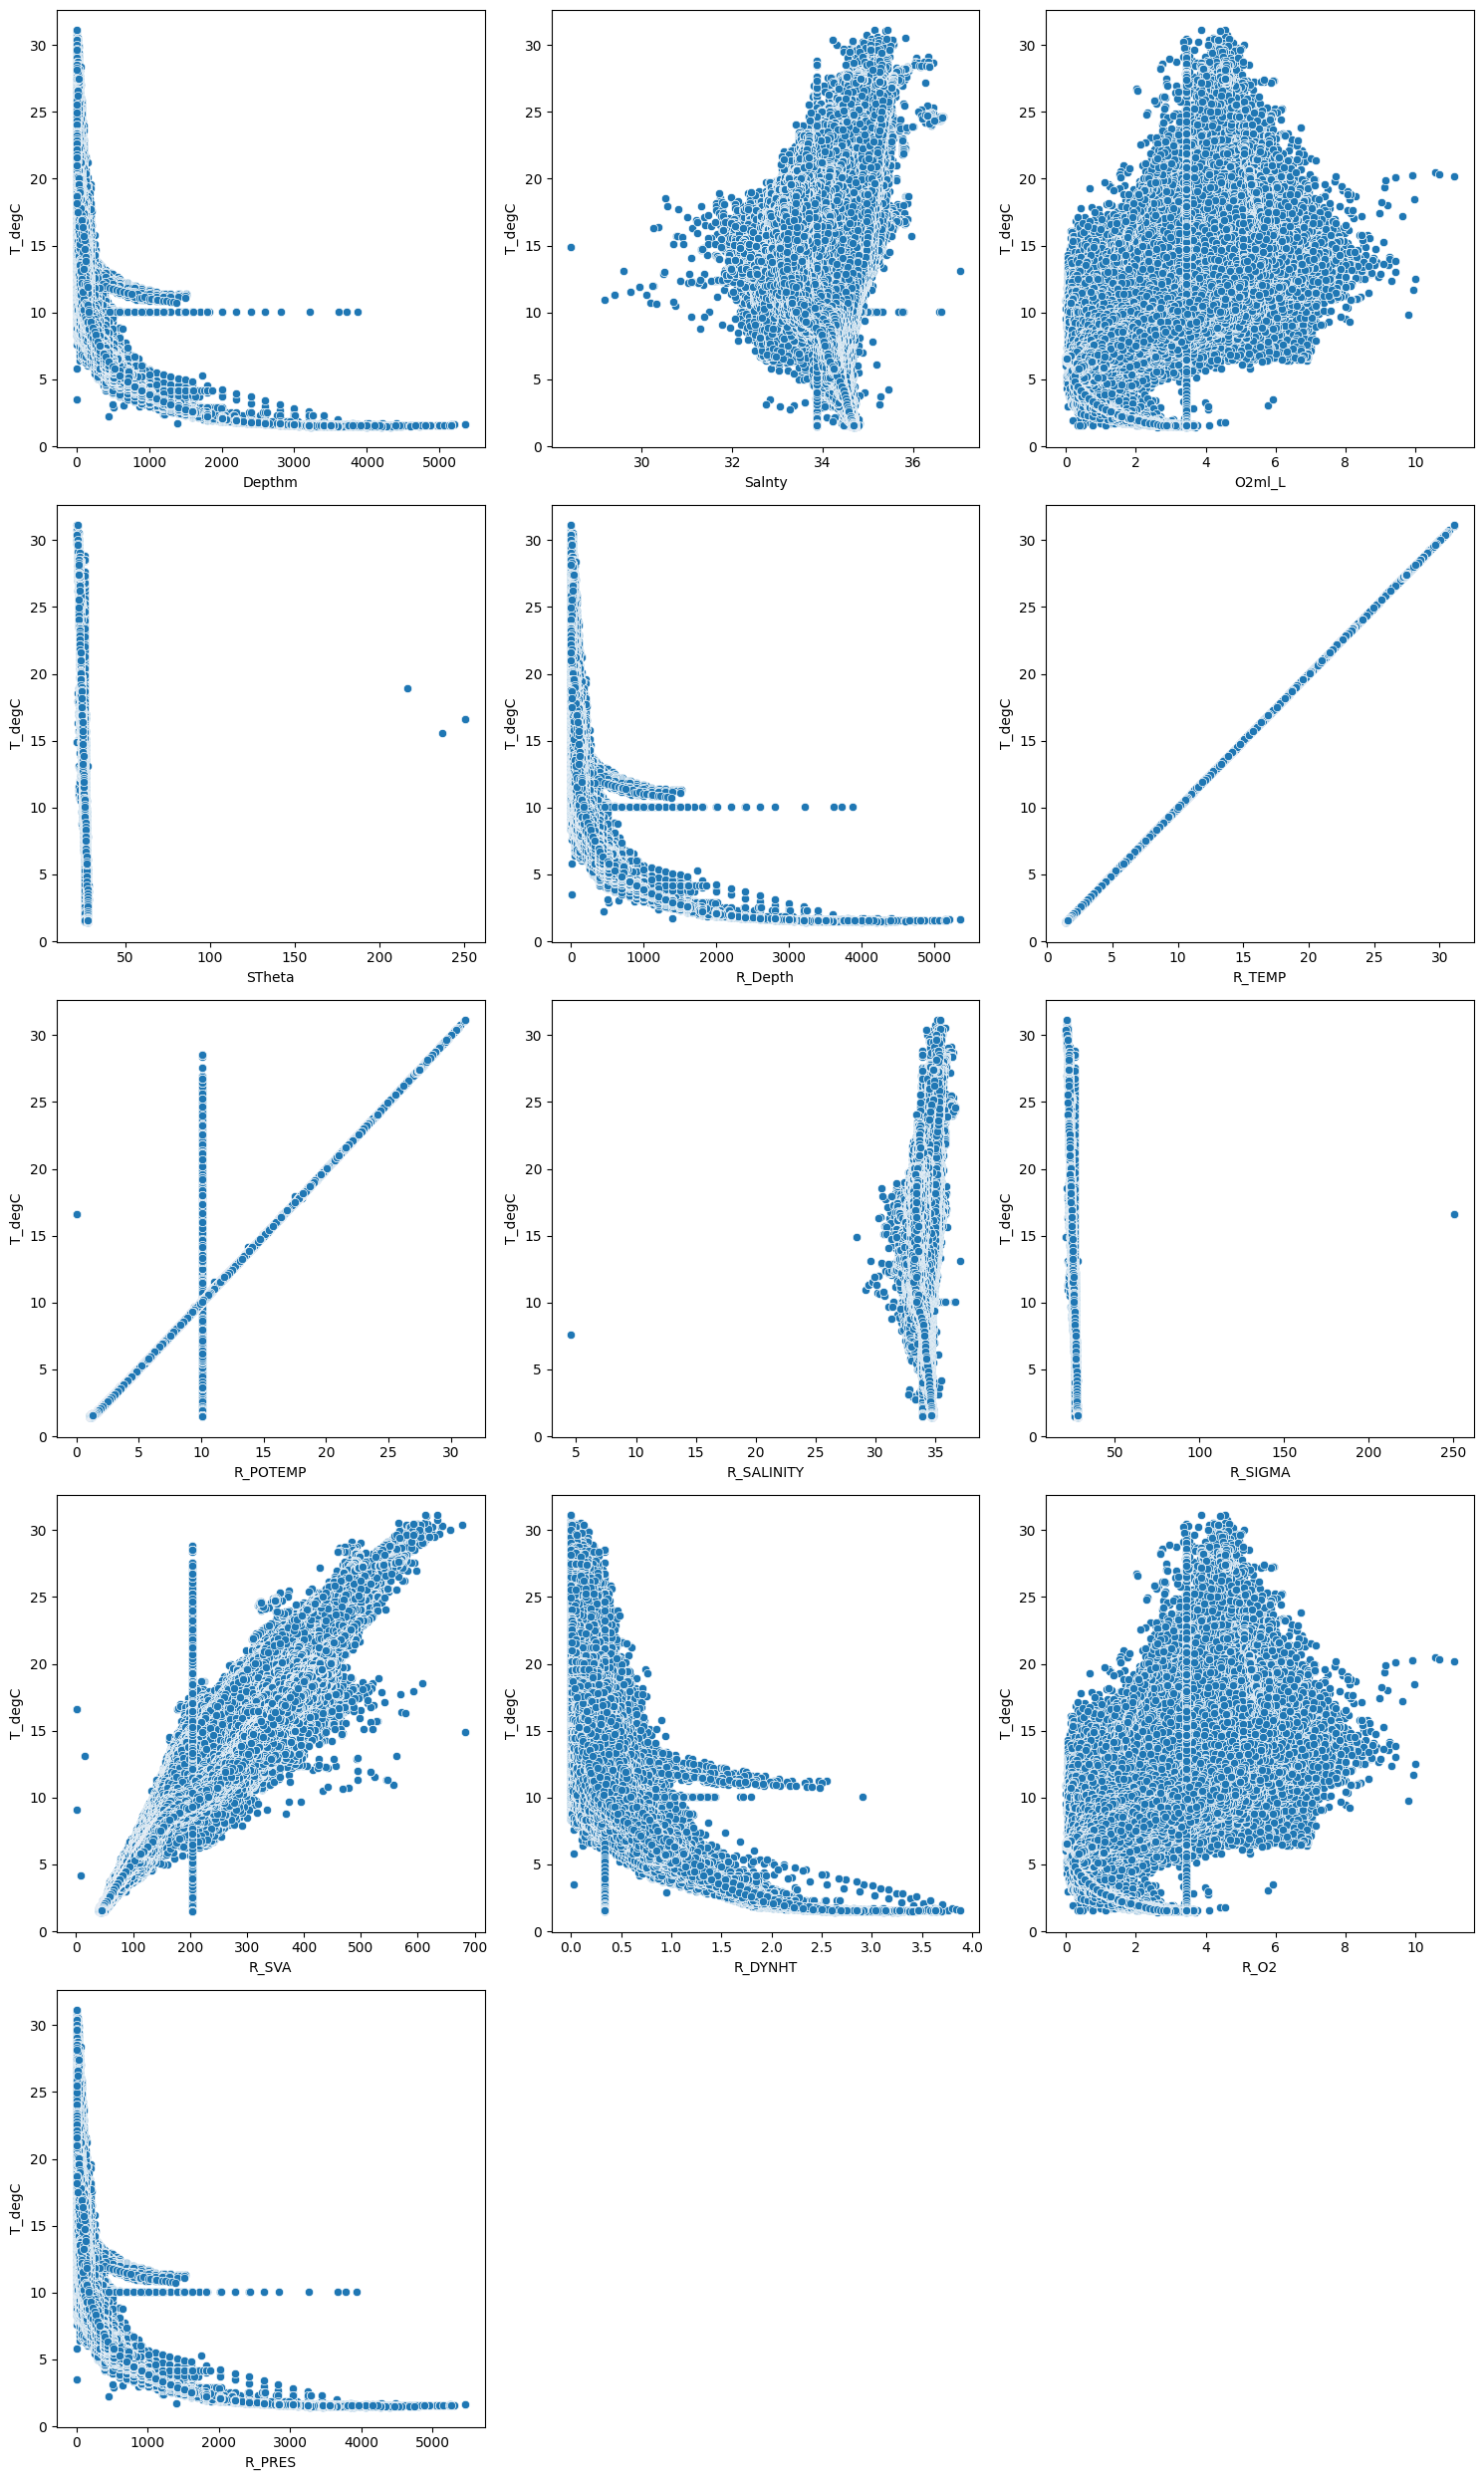

In [145]:
# Create a grid layout for the plots
cols = [col for col in new_bottle.columns if col != 'T_degC']
num_cols = len(cols)

# Define the number of rows and columns for the subplot grid
rows = (num_cols // 3) + (num_cols % 3 > 0)  # 3 plots per row
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plotting each scatterplot
for i, col in enumerate(cols):
    sns.scatterplot(x=new_bottle[col], y=new_bottle['T_degC'], ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('T_degC')

# Hide unused subplot spaces (if any)
for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


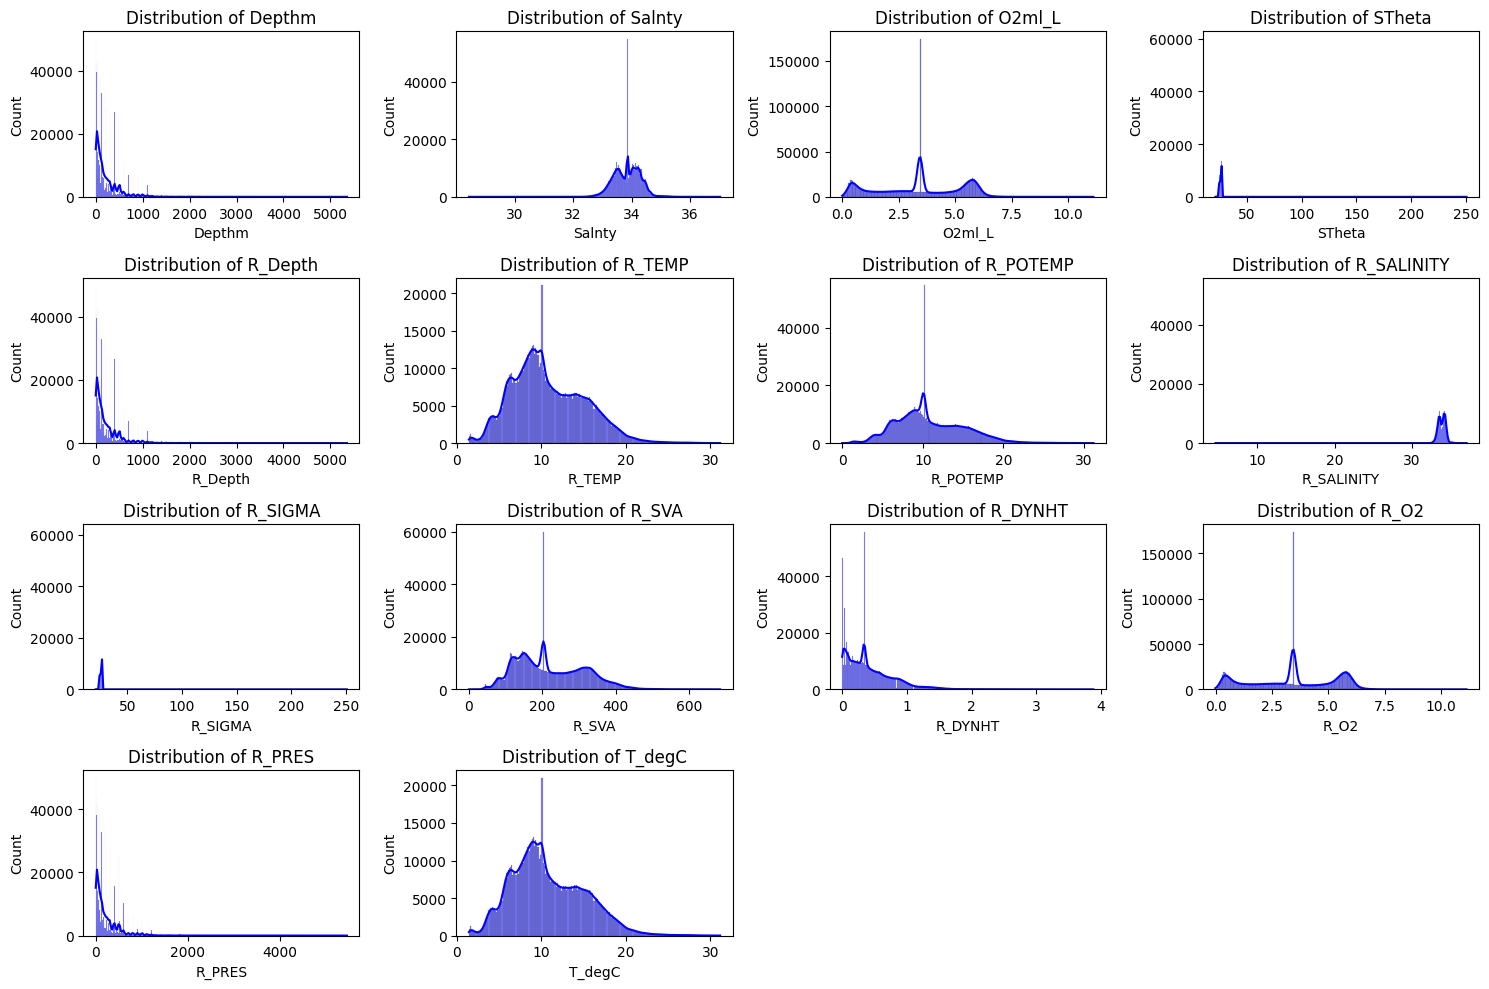

In [146]:
plt.figure(figsize=(15, 10))

# Plot histograms for all features and target
features = ['Depthm', 'Salnty', 'O2ml_L', 'STheta', 'R_Depth', 'R_TEMP', 'R_POTEMP', 
            'R_SALINITY', 'R_SIGMA', 'R_SVA', 'R_DYNHT', 'R_O2', 'R_PRES', 'T_degC']

for i, feature in enumerate(features):
    plt.subplot(4, 4, i + 1)
    sns.histplot(new_bottle[feature], kde=True, color='blue')
    plt.title(f'Distribution of {feature}')
    
plt.tight_layout()
plt.show()

In [147]:
# Calculate IQR for all numeric features
Q1 = new_bottle.quantile(0.25)
Q3 = new_bottle.quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = ((new_bottle < (Q1 - 1.5 * IQR)) | (new_bottle > (Q3 + 1.5 * IQR)))

# Show outliers in the DataFrame
print(f"N outliers before manipulation\n{outliers.sum()}")

N outliers before manipulation
Depthm        54779
Salnty         3626
O2ml_L            4
STheta          817
R_Depth       54779
R_TEMP         4017
R_POTEMP       5078
R_SALINITY     3627
R_SIGMA         772
R_SVA           891
R_DYNHT       26153
R_O2              4
R_PRES        54780
T_degC         4017
dtype: int64


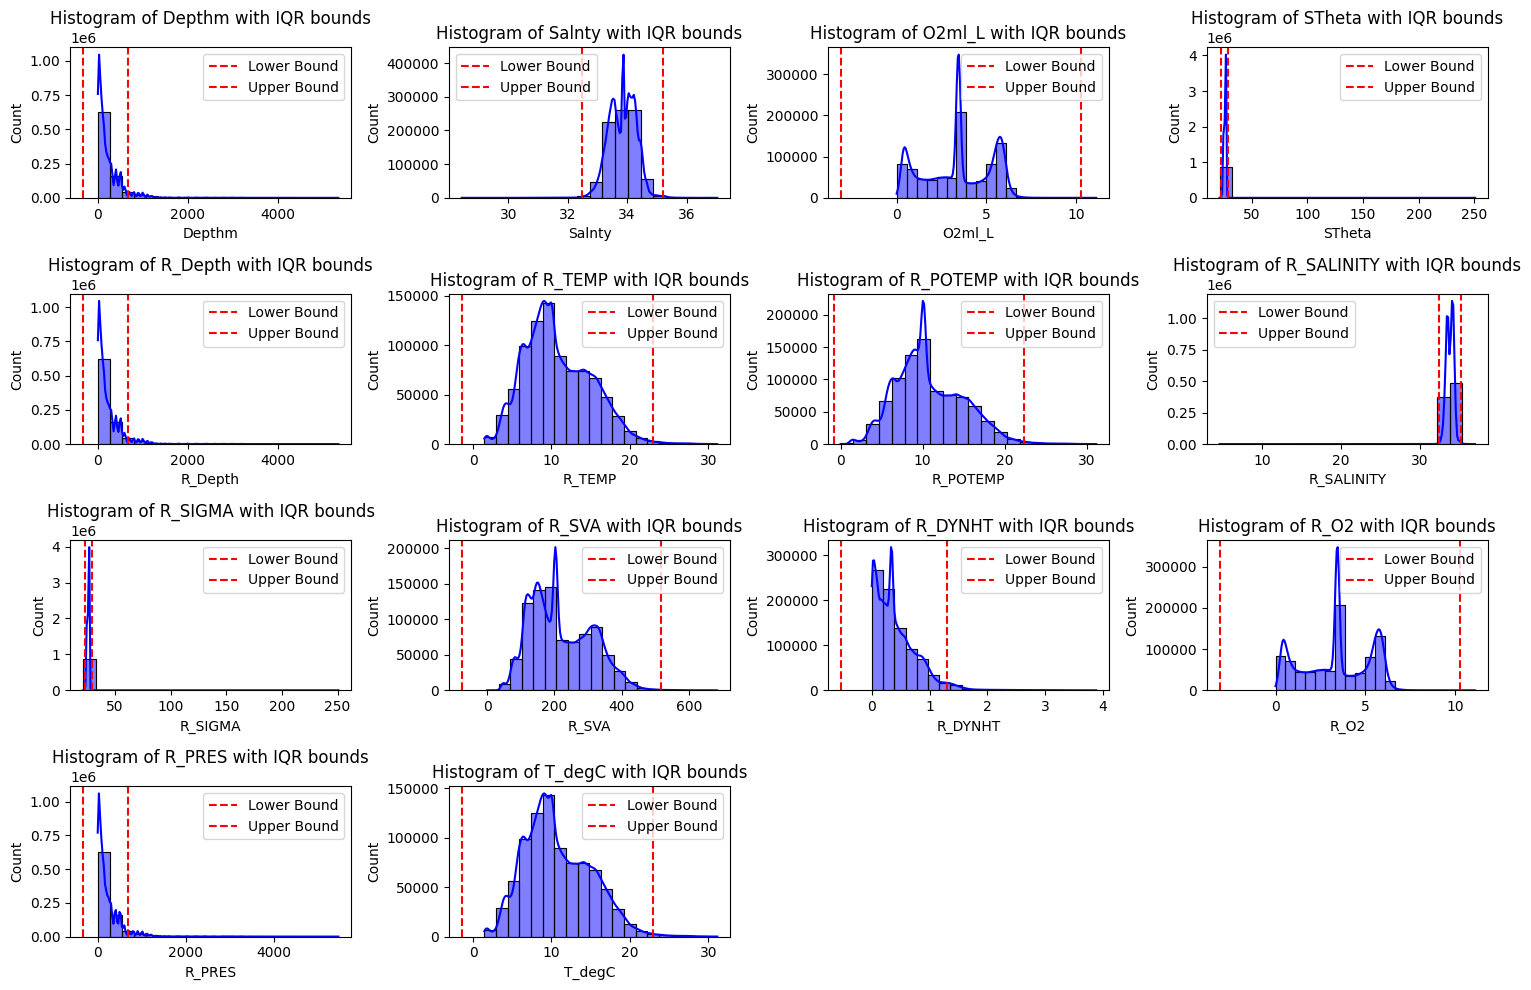

In [148]:
plt.figure(figsize=(15, 10))

# Plot histogram for each feature and mark the outlier thresholds
for i, feature in enumerate(features):
    plt.subplot(4, 4, i + 1)
    sns.histplot(new_bottle[feature], kde=True, color='blue', bins=20)
    plt.axvline(x=Q1[feature] - 1.5 * IQR[feature], color='r', linestyle='--', label="Lower Bound")
    plt.axvline(x=Q3[feature] + 1.5 * IQR[feature], color='r', linestyle='--', label="Upper Bound")
    plt.title(f"Histogram of {feature} with IQR bounds")
    plt.legend()
    
plt.tight_layout()
plt.show()

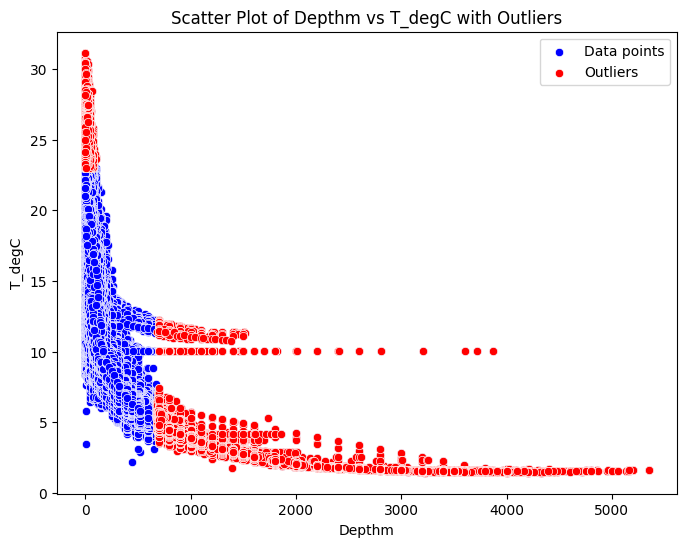

In [149]:
plt.figure(figsize=(8, 6))

# Choose two features to compare, e.g., 'Depthm' and 'T_degC'
sns.scatterplot(x=new_bottle['Depthm'], y=new_bottle['T_degC'], color='blue', label='Data points')

# Highlight the outliers based on IQR
outliers = ((new_bottle['Depthm'] < (Q1['Depthm'] - 1.5 * IQR['Depthm'])) | 
            (new_bottle['Depthm'] > (Q3['Depthm'] + 1.5 * IQR['Depthm'])) |
            (new_bottle['T_degC'] < (Q1['T_degC'] - 1.5 * IQR['T_degC'])) | 
            (new_bottle['T_degC'] > (Q3['T_degC'] + 1.5 * IQR['T_degC'])))

# Plot the outliers in red
sns.scatterplot(x=new_bottle.loc[outliers, 'Depthm'], y=new_bottle.loc[outliers, 'T_degC'], color='red', label='Outliers')

plt.title("Scatter Plot of Depthm vs T_degC with Outliers")
plt.legend()
plt.show()

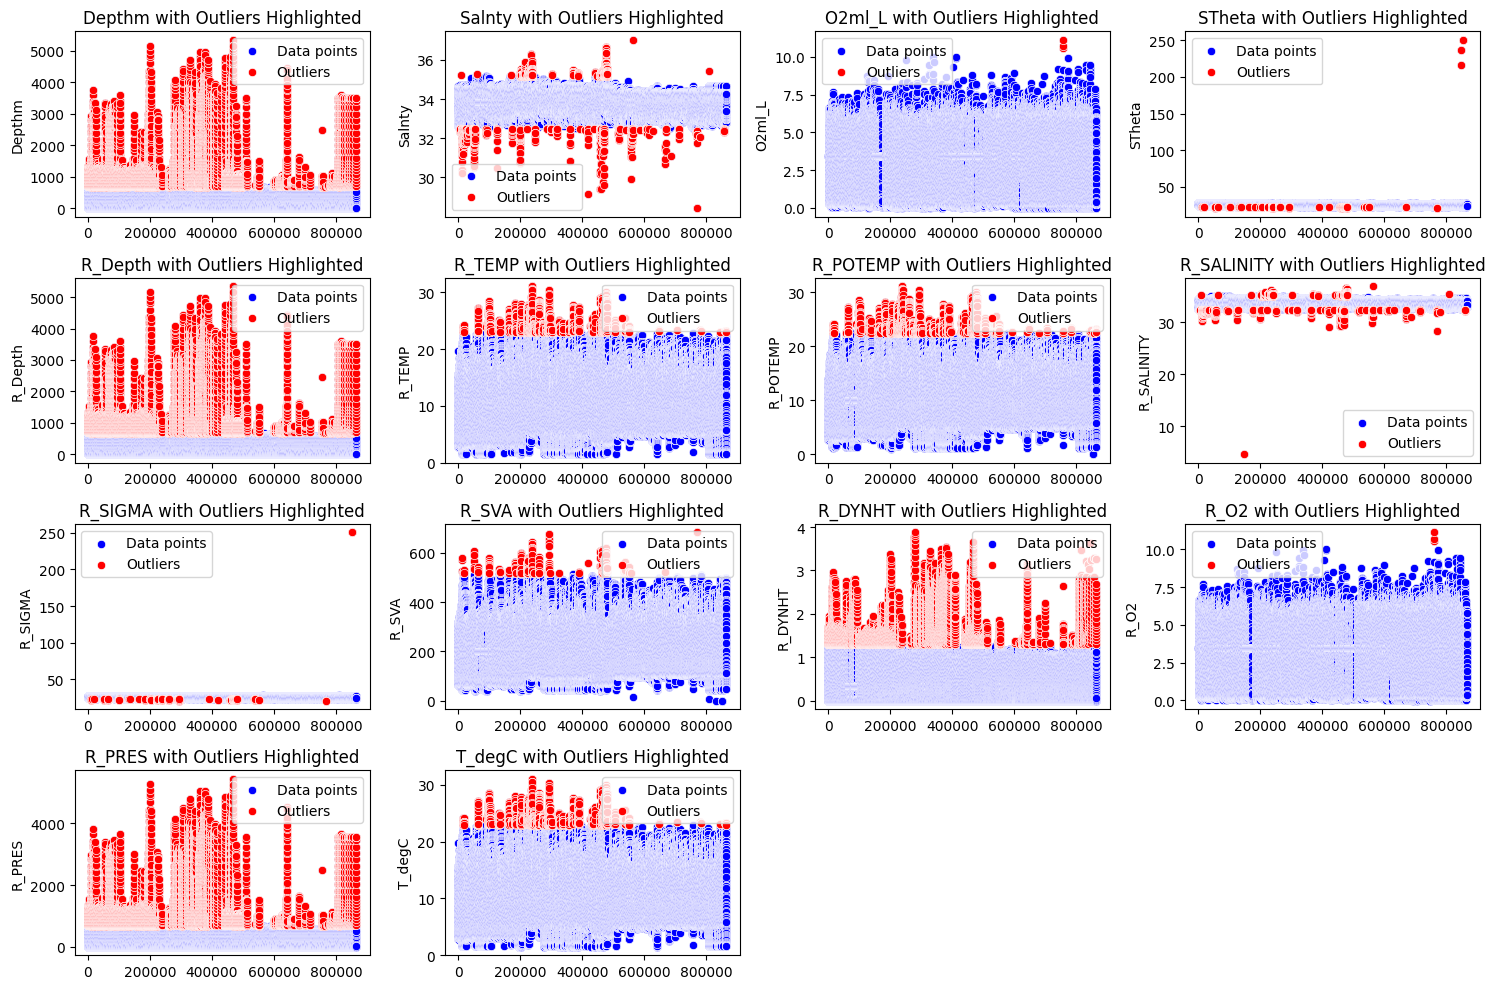

In [150]:
outliers = ((new_bottle < (Q1 - 1.5 * IQR)) | (new_bottle > (Q3 + 1.5 * IQR)))

# Scatter plot with outliers marked
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(4, 4, i + 1)
    sns.scatterplot(x=new_bottle.index, y=new_bottle[feature], color='blue', label="Data points")
    sns.scatterplot(x=new_bottle.loc[outliers[feature], :].index, y=new_bottle.loc[outliers[feature], feature], color='red', label="Outliers")
    plt.title(f"{feature} with Outliers Highlighted")
    plt.legend()

plt.tight_layout()
plt.show()

In [151]:
Q1 = new_bottle.quantile(0.25)
Q3 = new_bottle.quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = ((new_bottle < (Q1 - 1.5 * IQR)) | (new_bottle > (Q3 + 1.5 * IQR)))
# Replace outliers with the median
for col in new_bottle.columns:
    if new_bottle[col].dtype in ['float64', 'int64']:  # Only numeric columns
        median_value = new_bottle[col].median()
        new_bottle[col] = np.where(outliers[col], median_value, new_bottle[col])

# Define outliers
outliers = ((new_bottle < (Q1 - 1.5 * IQR)) | (new_bottle > (Q3 + 1.5 * IQR)))

# Show outliers after manipulation
print(f"N outliers after manipulation\n{outliers.sum()}")

N outliers after manipulation
Depthm        0
Salnty        0
O2ml_L        0
STheta        0
R_Depth       0
R_TEMP        0
R_POTEMP      0
R_SALINITY    0
R_SIGMA       0
R_SVA         0
R_DYNHT       0
R_O2          0
R_PRES        0
T_degC        0
dtype: int64


In [152]:
new_bottle.isnull().sum()

Depthm        0
Salnty        0
O2ml_L        0
STheta        0
R_Depth       0
R_TEMP        0
R_POTEMP      0
R_SALINITY    0
R_SIGMA       0
R_SVA         0
R_DYNHT       0
R_O2          0
R_PRES        0
T_degC        0
dtype: int64

## Prediction model

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [154]:
X = new_bottle.iloc[:, :-1]
y = new_bottle.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train set shape: ", X_train.shape)
print("X Test set shape: ", X_test.shape)
print("Y Train set shape: ", y_train.shape)
print("Y Test set shape: ", y_test.shape)

X Train set shape:  (691890, 13)
X Test set shape:  (172973, 13)
Y Train set shape:  (691890,)
Y Test set shape:  (172973,)


In [155]:
rf_reg = RandomForestRegressor(n_estimators=5, random_state=42)
rf_reg.fit(X_train,y_train)
pred_train = rf_reg.predict(X_train)
pred_test = rf_reg.predict(X_test)

In [156]:
# Evaluation
print(f"MAE: {mean_absolute_error(y_test, pred_test):.3f}")
print(f"R² Score: {r2_score(y_test, pred_test):.3f}")

MAE: 0.000
R² Score: 1.000


In [157]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train,y_train)
dt_predict_train = dt_reg.predict(X_train)
dt_predict_test = dt_reg.predict(X_test)

In [158]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluation function
def evaluate_model(y_true, y_pred, dataset_type="Train"):
    print(f"{dataset_type} Data Performance:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.3f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.3f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.3f}")
    print("-" * 40)

# Evaluate on both training and testing data
evaluate_model(y_train, dt_predict_train, "Train")
evaluate_model(y_test, dt_predict_test, "Test")


Train Data Performance:
MAE: 0.000
MSE: 0.000
RMSE: 0.000
R² Score: 1.000
----------------------------------------
Test Data Performance:
MAE: 0.000
MSE: 0.000
RMSE: 0.001
R² Score: 1.000
----------------------------------------
